In [1]:
from importlib import reload
import gnn_tracking_hpo
reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path, find_checkpoint

add_scripts_path()

In [2]:
from tune_fixed_ec import PretrainedECTrainable

In [3]:
PretrainedECTrainable._device = "cpu"

In [4]:
project = "fixed-ec-51f87ec0"
hash = "af5b5461"

In [5]:
from gnn_tracking_hpo.util.paths import get_config

config = get_config(project, hash)
config["n_graphs_train"] = 1
config["n_graphs_val"] = 1
config["n_graphs_test"] = 1
config["ec_epoch"] = -1
# config["m_ec_threshold"] = 0.0

[11:09:54 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-51f87ec0/PretrainedECTrainable_af5b5461_4_attr_pt_thld=0.6079,batch_size=5,ec_epoch=32,ec_hash=51f87ec0,ec_project=ec,ec_pt_thld=0.0000,gnn_2023-02-01_10-37-15/params.json


In [6]:
trainable = PretrainedECTrainable(config)

trainable.load_checkpoint(find_checkpoint(project, hash, -1), device="cpu")

[11:09:54 gnnt_hpo] INFO: Initializing pre-trained EC
[11:09:56 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_51f87ec0_1_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=f2480a9a_2023-01-30_23-14-13/params.json
[11:09:57 gnnt_hpo] INFO: I'm running on a node with job ID=45725815
[11:09:57 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[11:09:57 gnnt_hpo] INFO: The ID of my dispatcher is 0
[11:09:57 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[11:09:57 gnnt_hpo] DEBUG: Got config
{'batch_size': 5,
 'ec_loss': 'focal',
 'ec_pt_thld': 0.7710612479097784,
 'focal_alpha': 0.3824243521658318,
 'focal_gamma': 2.5581270116033084,
 'gnn_tracking_experiments_hash': 'f2480a9ace4e343690a7d852cb8a5026d146484d',
 'gnn_tracking_hash': '289dbf3026f58d1e6d154fe6e3aa40d06aded58c',
 'lr': 0.00049290409721272

In [7]:
#results = trainable.trainer.test_step()

In [8]:
#trainable.trainer._log_losses(results)

In [9]:
from gnn_tracking.graph_construction.graph_builder import load_graphs

graphs = load_graphs("/scratch/gpfs/kl5675/data/gnn_tracking/graphs/training_part09", stop=10, n_processes=6)

[11:10:00] INFO: Loading 10 graphs (out of 3200 available).
[11:10:00] DEBUG: First graph is data29004_s0.pt, last graph is data29004_s17.pt


In [10]:
from torch_geometric.loader import DataLoader

loader = DataLoader(graphs, num_workers=6)

In [39]:
import torch
from tqdm import tqdm


trainer = trainable.trainer
trainer.model.eval()

study_input = []

interesting_keys = ["x", "beta", "particle_id", "ec_hit_mask"]

stop = None
with torch.no_grad():
    for idx, data in tqdm(enumerate(loader), total=len(graphs)):
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        study_input.append(
            {key: model_output[key].cpu().numpy() for key in interesting_keys}
        )
        if idx == stop:
            break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


In [40]:
import matplotlib.pyplot as plt
import copy
import numpy as np

In [43]:
masked_study_input = copy.deepcopy(study_input)
for key in ["particle_id"]:
    for item in masked_study_input:
        item[key] = item[key][item["ec_hit_mask"]]
for item in masked_study_input:
    item["r"] = item["x"][:, 0]

In [46]:
fc = masked_study_input[0]

selected_pids = np.random.choice(fc["particle_id"], 10)

(array([ 38.,  37.,  69.,  71.,  75.,  94., 116.,  42.,  46.,  32.]),
 array([-6.86926889, -6.02433825, -5.1794076 , -4.33447695, -3.48954606,
        -2.64461541, -1.79968464, -0.95475394, -0.10982323,  0.73510748,
         1.58003819]),
 <BarContainer object of 10 artists>)

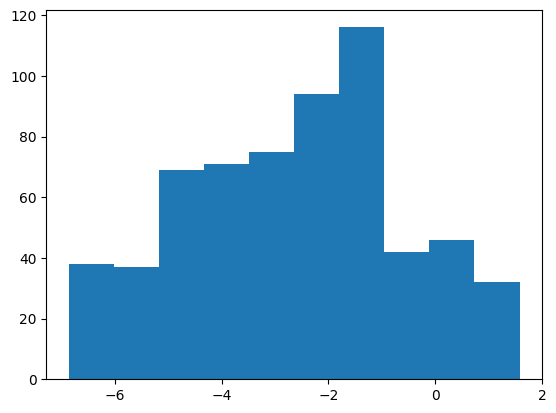

In [55]:
plt.hist(fc["x"][:, 3])

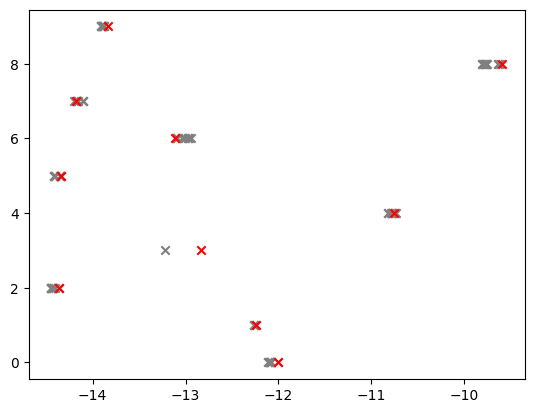

In [58]:
fig, ax = plt.subplots()
for ipid, pid in enumerate(selected_pids):
    mask = fc["particle_id"] == pid
    xs = fc["r"][mask]
    ys = np.array([ipid] * mask.sum())
    condensation_beta = np.max(fc["beta"][mask])
    is_condensation_mask = fc["beta"][mask] == condensation_beta
    ax.scatter(xs[~is_condensation_mask], ys[~is_condensation_mask], marker="x", color="gray")
    ax.scatter(xs[is_condensation_mask], ys[is_condensation_mask], marker="x", color="red")

In [ ]:
[~is_condensation_mask]